# MS Pacman Gym

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [2]:
import gym

In [3]:
env = gym.make('MsPacman-v0')

[2018-02-01 05:43:27,556] Making new env: MsPacman-v0


In [4]:
import time

def show_state(raw_image, step=0, info="", delay=0.):
    """Render an image of the environment"""
    plt.figure(3)
    plt.clf()
    try:
        plt.imshow(raw_image)
    except TypeError:
        plt.imshow(raw_image, cmap='gray')
    plt.title(f"{env.spec.id} | Step: {step} {info}")
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(delay)

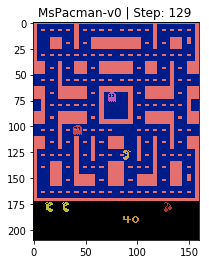

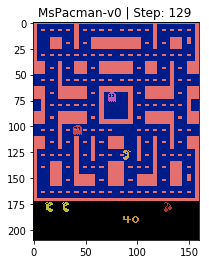

In [5]:
env.reset()

for step in range(130):
    env.step(env.action_space.sample())
    if step > 80:
        show_state(env.render(mode='rgb_array'), step=step)

# Preprocess Images of Ms Pacman

In [6]:
import numpy as np

In [7]:
env.reset().shape

(210, 160, 3)

In [8]:
def shrink_mspacman(obs):
    mspacman_color = np.array([210, 164, 74]).mean()
    
    img = obs[1:176:2, ::2]        # crop bottom and downsize by losing every second pixel
    img = img.mean(axis=2)         # average across channels to greyscale
    img[img==mspacman_color] = 0   # improve contrast
    
    img = (img - 256)/128          # normalize to -1 to 1
    return img    

In [9]:
def preprocess_observation(obs):
    img = shrink_mspacman(obs)
    h, w = img.shape
    return img.reshape((h,w,1))

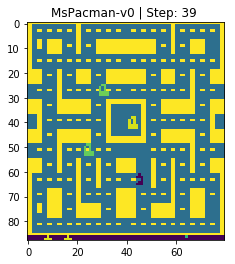

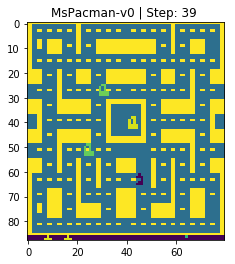

In [10]:
env.reset()

for _ in range(80):
    _,_, done, _ = env.step(env.action_space.sample())

for step in range(40):
    _,_, done, _ = env.step(env.action_space.sample())
    env_image = shrink_mspacman(env.render(mode='rgb_array'))
    show_state(env_image, step=step, )

In [11]:
env_image.shape

(88, 80)

## The Neural networks
Define the actor and the critic networks.

In [12]:
import tensorflow as tf
from tensorflow.contrib.layers import convolution2d, fully_connected

In [13]:
initializer = tf.contrib.layers.variance_scaling_initializer()
learning_rate = 0.01

In [14]:
# input Parameters
input_height, input_width = env_image.shape
input_channels = 1

In [15]:
# convolution parameters
conv_maps = [32,64,64]
conv_kernals_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4,2,1]
conv_padding = ["SAME"]*3
conv_activation = [tf.nn.relu]*3

conv_parameters = zip(conv_maps, conv_kernals_sizes, conv_strides, conv_padding, conv_activation)

In [16]:
# hidden layer parameters
n_hidden_in = 64 * 11 * 10
n_hidden = 512
hidden_activation = tf.nn.relu

In [17]:
n_hidden_in

7040

In [18]:
# output size
n_outputs = env.action_space.n

In [19]:
# the Q network
def q_network(X_state, scope):
    prev_layer = X_state
    conv_layers = []
    
    with tf.variable_scope(scope) as scope:
        # add the convolution layers to scope
        for n_maps, kernel_size, stride, padding, activtion in conv_parameters:
            prev_layer = convolution2d(prev_layer, 
                                       num_outputs=n_maps,
                                       kernel_size=kernel_size,
                                       stride=stride,
                                       padding=padding,
                                       activation_fn=activtion,
                                       weights_initializer=initializer,
                                      )
            conv_layers.append(prev_layer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1,n_hidden_in])
        
        # add the hidden layer to scope
        hidden = fully_connected(last_conv_layer_flat,
                                 n_hidden,
                                 activation_fn=hidden_activation,
                                 weights_initializer=initializer,
                                )
        
        # add output layer to scope
        outputs = fully_connected(hidden,
                                  n_outputs,
                                  activation_fn=None,
                                  weights_initializer=initializer,
                                 )
    # return trainable variable pointers
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name)]: var for var in trainable_vars}
    return outputs, trainable_vars_by_name
    

In [20]:
# Initial state
X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width, input_channels])

In [21]:
# define the Q networks for the actor and critic
actor_q_values, actor_variables = q_network(X_state, scope='q_network/actor')
critic_q_values, critic_variables = q_network(X_state, scope='q_network/critic')

In [22]:
# copy critic to actor
copy_ops = [actor_var.assign(critic_variables[var_name]) for var_name, actor_var in actor_variables.items()]
copy_critic_to_actor = tf.group(*copy_ops)

In [23]:
# calculate the Q-value of the action taken by the actor
X_action = tf.placeholder(tf.int32, shape=[None])
q_value = tf.reduce_sum(critic_q_values * tf.one_hot(X_action, n_outputs), axis=1, keep_dims=True)

In [24]:
# training operations
y = tf.placeholder(tf.float32, shape=[None,1])
cost = tf.reduce_mean(tf.square(y - q_value))

global_step = tf.Variable(0, trainable=False, name='global_step')
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(cost, global_step=global_step)

In [25]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

## Memory sampling for critic

In [26]:
from collections import deque

In [27]:
# memory setup
replay_memory_size = 1000
replay_memory = deque([], maxlen=replay_memory_size)

In [28]:
def sample_memories(batch_size):
    indices = np.random.permutation(len(replay_memory))[:batch_size]
    cols = [[], [], [], [], []]    # state, action, reward, next_state, continue

    for idx in indices:
        memory = replay_memory[idx]
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1,1), cols[3], cols[4].reshape(-1,1)

## Exploring policy parameters for actor

In [29]:
epsilon_min = 0.05
epsilon_max = 1.
epsilon_decay_steps = 50000

In [30]:
def epsilon_greedy_policy(q_values, step):
    interpolate = (epsilon_max - epsilon_min) * step / epsilon_decay_steps
    epsilon = max(epsilon_min, epsilon_max - interpolate)
    
    # random if less than epsilon else optimal
    return np.random.randint(n_outputs) if np.random.rand() < epsilon else np.argmax(q_values)

## Test Actor

In [31]:
test_env = gym.make('MsPacman-v0')

[2018-02-01 05:43:40,380] Making new env: MsPacman-v0


In [32]:
def observe_actor_play():
    obs = test_env.reset()

    for _ in range(80):
        obs, _, done, _ = test_env.step(0)
    
    state = preprocess_observation(obs)
    
    while not done:
        # actor evaluates the position
        q_values = actor_q_values.eval(feed_dict={X_state: [state]})
        # choose and take action
        action = epsilon_greedy_policy(q_values, step)
        obs, reward, done, _ = test_env.step(action)
        test_env.step(action)
        show_state(test_env.render(mode='rgb_array'), step=step)

# Training

In [33]:
import os

In [34]:
# parameters
skip_start = 80         # skip the start of every game, as it is just waiting
training_burnin = 100     # train after 1000 game iterations
training_interval = 3   # run a training step every __ game iterations
batch_size = 5

n_steps = 200         # total number of training steps
save_steps = 50         # save the model every __ training steps
copy_steps = 25         # copy the critic to actor every __ steps
observe_steps = 2*copy_steps      # observe the actor play 

discount_rate = 0.95    #
checkpoint_path = './my_dqn.ckpt'

In [35]:
def reset_game_environment():
    obs = env.reset()
    for _ in range(skip_start-1):
        env.step(0)
    return env.step(0)  # return obs, reward, done, info

In [36]:
def take_and_memorize_game_steps():
    iteration = 0     # game iterations
    done = True       # initial value for the trigger to reset the game environment
    
    while True:
        if done:
            obs, reward, done, _ = reset_game_environment()
            state = preprocess_observation(obs)

        # actor evaluate the position
        q_values = actor_q_values.eval(feed_dict={X_state: [state]})
        
        # choose and take action
        action = epsilon_greedy_policy(q_values, step)
        obs, reward, done, _ = env.step(action)
        
        # memorize what occurred
        next_state = preprocess_observation(obs)
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state
        
        if iteration >= training_burnin and iteration % training_interval == 0:  
            yield
        iteration += 1

In [37]:
def teach_critic():
    # sample some memories
    X_state_val, X_action_val, rewards, X_next_state_val, continues = sample_memories(batch_size)
    
    # calculate actor's Q-values aka estimations of future reward
    next_q_values = actor_q_values.eval(feed_dict={X_state: X_next_state_val})
    
    # pick out the maximum Q-values for each state
    max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
    
    # calculate the real rewards plus the actor's prediction
    y_val = rewards + continues * discount_rate * max_next_q_values
    
    # train critic
    training_op.run(feed_dict={X_state: X_state_val, X_action: X_action_val, y: y_val})

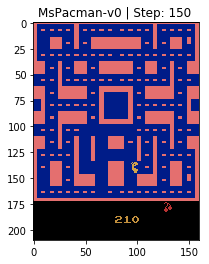

copy critic to actor


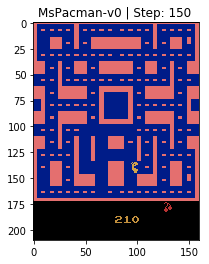

In [38]:
# training session
with tf.Session() as session:
    # restore previous checkpoint
    if os.path.isfile(checkpoint_path):
        saver.restore(session, checkpoint_path)
    else:
        init.run()

    for _ in take_and_memorize_game_steps():
        step = global_step.eval()
        if step >= n_steps:
            break
            
        teach_critic()

        # copy, save, and observe. Then increment step
        if step % copy_steps == 0:
            print('copy critic to actor')
            copy_critic_to_actor.run()
        #if step % save_steps == 0:
            #saver.save(session, checkpoint_path) 
        if step % observe_steps == 0:
            observe_actor_play()


In [39]:
88*80*10

70400